# Complete experiment to try to estimate the probability of an offer to "succeed" with one customer. The "informative" offers are considered successful if the customer views them. Other kinds of offers are successful only if the customer views them, and then completes them.

Table of contents <a id='top'>

1. [Get the data and show it](#data)
2. [Create the Model](#model)
3. [Evaluate the Model](#eval)
4. [Analysis and Conclusions](#conclusions)
5. [Test Results](#test)

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.visualization.visualize as vis

## 1. Get the data and show it <a id='data'/>
[Top](#top)

In [2]:
# Get the data
STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster3d.pkl')

X_train_val, X_test, y_train_val, y_test, encoder = sd.get_success_data(
    basic_dataset_path=STATIC_DATASET_PATH,
    drop_time=False)

# Time-split validation datasets
X_test = sd.drop_time_dependent(X_test)
X_train, X_val, y_train, y_val = sd.time_split(X_train_val, 
                                               y_train_val,
                                               time_limit=370)

In [3]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(38030, 24)
(38030,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,ward_12,dbscan_10,3d_kmeans_3,3d_ward_3,3d_ward_9,3d_ward_19,3d_gmm_3,3d_gmm_16,3d_dbscan_02_20,3d_dbscan_05_100
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,...,8.0,1.0,0.0,1.0,3.0,4.0,2.0,12.0,-1.0,0.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,...,8.0,1.0,0.0,1.0,3.0,4.0,2.0,12.0,-1.0,0.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,...,9.0,-1.0,0.0,1.0,4.0,8.0,2.0,12.0,0.0,0.0
8,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,1.0,...,9.0,-1.0,0.0,1.0,4.0,8.0,2.0,12.0,0.0,0.0


In [4]:
print(X_val.shape)
print(y_val.shape)
X_val.head()

(12778, 24)
(12778,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,ward_12,dbscan_10,3d_kmeans_3,3d_ward_3,3d_ward_9,3d_ward_19,3d_gmm_3,3d_gmm_16,3d_dbscan_02_20,3d_dbscan_05_100
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,...,8.0,1.0,0.0,1.0,3.0,4.0,2.0,12.0,-1.0,0.0
10,40.0,O,57000.0,0,17540,20.0,10.0,discount,5.0,1.0,...,9.0,-1.0,0.0,1.0,4.0,8.0,2.0,12.0,0.0,0.0
15,59.0,F,90000.0,0,16864,10.0,5.0,bogo,10.0,1.0,...,4.0,0.0,1.0,3.0,7.0,14.0,1.0,13.0,-1.0,0.0
19,24.0,F,60000.0,0,17116,0.0,3.0,informational,0.0,0.0,...,1.0,-1.0,0.0,1.0,3.0,4.0,0.0,5.0,-1.0,0.0
24,26.0,F,73000.0,0,17338,10.0,10.0,discount,2.0,1.0,...,1.0,-1.0,0.0,1.0,3.0,4.0,2.0,1.0,-1.0,0.0


In [5]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(25469, 24)
(25469,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,ward_12,dbscan_10,3d_kmeans_3,3d_ward_3,3d_ward_9,3d_ward_19,3d_gmm_3,3d_gmm_16,3d_dbscan_02_20,3d_dbscan_05_100
3,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,1.0,...,8.0,1.0,0.0,1.0,3.0,4.0,2.0,12.0,-1.0,0.0
4,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,1.0,...,8.0,1.0,0.0,1.0,3.0,4.0,2.0,12.0,-1.0,0.0
6,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,40.0,O,57000.0,0,17540,5.0,7.0,bogo,5.0,1.0,...,9.0,-1.0,0.0,1.0,4.0,8.0,2.0,12.0,0.0,0.0
16,59.0,F,90000.0,0,16864,0.0,3.0,informational,0.0,0.0,...,4.0,0.0,1.0,3.0,7.0,14.0,1.0,13.0,-1.0,0.0


## 2. Create the model <a id='model'/>
[Top](#top)

In [6]:
cluster1_feats = ['kmeans_8', 'ward_12', 'dbscan_10']
cluster3d_feats = ['3d_kmeans_3', '3d_ward_3', '3d_ward_9', '3d_ward_19',
                 '3d_gmm_3', '3d_gmm_16', '3d_dbscan_02_20', '3d_dbscan_05_100']

base_model = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.BasicImputer(fill_mode=cluster1_feats + cluster3d_feats)),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=200, n_jobs=-1,
                                random_state=2018))
])

In [7]:
# Grid search for better parameters

parameters = {
    'estimator__max_depth': [4, 7],
    'estimator__n_estimators': [10, 200, 500],
    'estimator__subsample': [0.5, 1.0],
    'estimator__colsample_bytree': [0.5, 0.7, 1.0],
    'estimator__colsample_bylevel': [0.5, 0.7, 1.0]
}
cv = GridSearchCV(base_model, parameters, cv=3, n_jobs=-1)

%time cv.fit(X_train, y_train)

print('The best parameters are:')
print(cv.best_params_)
print('-'*100)

model = cv.best_estimator_
model.get_params()

CPU times: user 7.82 s, sys: 344 ms, total: 8.16 s
Wall time: 39min 12s
The best parameters are:
{'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bytree': 0.5, 'estimator__max_depth': 4, 'estimator__n_estimators': 200, 'estimator__subsample': 1.0}
----------------------------------------------------------------------------------------------------


{'memory': None,
 'steps': [('encoder', BasicEncoder()),
  ('imputer', BasicImputer(fill_mode=['kmeans_8', 'ward_12', 'dbscan_10'])),
  ('estimator',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
          colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
          max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
          n_jobs=-1, nthread=None, objective='binary:logistic',
          random_state=2018, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=True, subsample=1.0))],
 'encoder': BasicEncoder(),
 'imputer': BasicImputer(fill_mode=['kmeans_8', 'ward_12', 'dbscan_10']),
 'estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
        colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
        max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
        n_jobs=-1, nthread=None, objective='binary:logistic',
        random_state=2018, reg_al

## 3. Evaluate the model <a id='eval'/>
[Top](#top)

### Time-split Validation

In [8]:
trained_model, y_train_pred, y_val_pred = evos.time_split_validation(model, 
                                                                     basic_dataset_path=STATIC_DATASET_PATH)

Training time: 3.220839023590088 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[15325  4807]
 [ 5298 12600]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     20132
           1       0.72      0.70      0.71     17898

   micro avg       0.73      0.73      0.73     38030
   macro avg       0.73      0.73      0.73     38030
weighted avg       0.73      0.73      0.73     38030

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[4962 1781]
 [2025 4010]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      6743
           1       0.69      0.66      0.68      6035

   micro avg       0.70

### Customer-split validation

In [9]:
evos.random_1fold_cust_validation(model, basic_dataset_path=STATIC_DATASET_PATH)

Training time: 3.1294164657592773 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[14216  4611]
 [ 4977 11702]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     18827
           1       0.72      0.70      0.71     16679

   micro avg       0.73      0.73      0.73     35506
   macro avg       0.73      0.73      0.73     35506
weighted avg       0.73      0.73      0.73     35506

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5931 2117]
 [2290 4964]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      8048
           1       0.70      0.68      0.69      7254

   micro avg       0.7

## 4. Analysis and Conclusions <a id='conclusions'/>
[Top](#top)

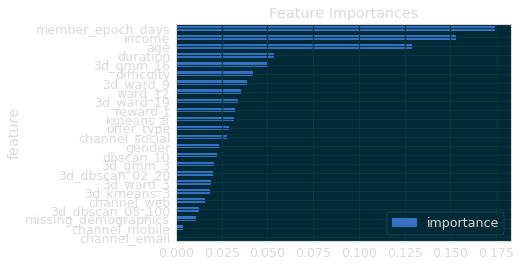

<Figure size 432x288 with 0 Axes>

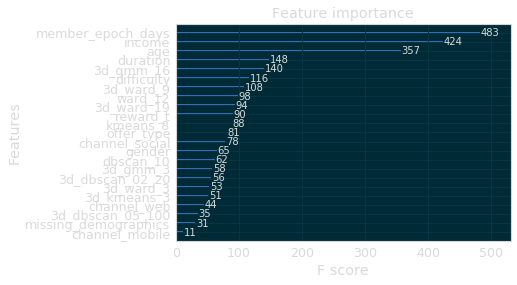

In [10]:
vis.show_feat_importances(model, X_train)

The cluster features are taken into account, but they are not too relevant, and don't seem to change the results too much.

## 5. Test Results (only run this once, after adjusting all the hyperparameters) <a id='test'/>
[Top](#top)

In [11]:
evos.offer_success_test(model, basic_dataset_path=STATIC_DATASET_PATH)

Training time: 4.547874212265015 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[20188  6687]
 [ 7238 16695]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74     26875
           1       0.71      0.70      0.71     23933

   micro avg       0.73      0.73      0.73     50808
   macro avg       0.73      0.72      0.72     50808
weighted avg       0.73      0.73      0.73     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10180  3808]
 [ 3512  7969]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74     13988
           1       0.68      0.69      0.69     11481

   micro avg       